In [6]:
import time

import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

def initialize_weights(model, scheme):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if scheme == 'naive':
                nn.init.normal_(layer.weight, mean=0.0, std=1.0)
                if layer.bias is not None:
                    nn.init.normal_(layer.bias, mean=0.0, std=1.0)
            elif scheme == 'glorot_uniform':
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            elif scheme == 'glorot_normal':
                nn.init.xavier_normal_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            else:
                raise ValueError(f"{scheme} is an unknown scheme for weights initialization")

torch.manual_seed(2008)
device = 'cuda'

# Problem definition
""" --- ОДНОМЕРНЫЙ ЗАТУХАЮЩИЙ ГАРМОНИЧЕСКИЙ ОСЦИЛЛЯТОР ---
u'' + 2 * delta * u' + omega0^2 * u = 0, где delta = mu/(2m), omega0 = sqrt(k/m)   (случай с затуханиями: delta < omega0)
u(0)  = 1,
u'(0) = 0.
u_exact(t) = 2 * A * exp(-delta * t) * cos(phi + omega * t), 
где omega = sqrt(omega0^2 - delta^2), 
    phi   = arctg(-delta/omega), 
    A     = 1 / (2 * cos(phi))"""
delta, omega0 = 2, 20
domain = [0, 1]    # t_min, t_max

# Training parameters
n_points = 1000
n_epochs = 5000
lambda_ic, lambda_r = 1, 1
causal_m = 10
causal_eps = 100

# Model
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 256), nn.Tanh(), 
            nn.Linear(256, 256), nn.Tanh(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        n = self.net(x)
        return 1.0 + x**2 * n
model = MyNet().to(device)
initialize_weights(model, "glorot_normal")

#t = torch.linspace(*domain, n_points + 1, device=device).reshape(-1, 1)
#t_ic = t[0:1].requires_grad_(True)
#t_r = t[1:].requires_grad_(True)
t_r = torch.rand((n_points, 1), device=device, requires_grad=True)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-2)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1.0/10000))

loss_log = torch.zeros(n_epochs)
loss_r_log = torch.zeros(n_epochs)
#loss_ic_log = torch.zeros(n_epochs)

pbar = trange(n_epochs)
for iter in pbar:
    optimizer.zero_grad()

    #t_r = torch.rand((n_points, 1), device=device, requires_grad=True)

    u_r = model(t_r)
    #u_ic = model(t_ic)

    du_dt = torch.autograd.grad(u_r, t_r, grad_outputs=torch.ones_like(u_r), create_graph=True)[0]
    d2u_dt2 = torch.autograd.grad(du_dt, t_r, grad_outputs=torch.ones_like(du_dt), create_graph=True)[0]
    res_r = d2u_dt2 + 2*delta*du_dt + omega0*omega0*u_r
    #res_ic1 = u_ic - torch.ones_like(u_ic)
    #res_ic2 = torch.autograd.grad(u_ic, t_ic, grad_outputs=torch.ones_like(u_ic), create_graph=True)[0]

    loss_r = torch.mean(res_r**2)
    #loss_ic = torch.mean(res_ic1**2) + torch.mean(res_ic2**2)
    loss = lambda_r * loss_r# + lambda_ic * loss_ic

    loss.backward()
    optimizer.step()
    #scheduler.step()

    if iter % 1 == 0:
        loss_log[iter] = loss.item()
        loss_r_log[iter] = loss_r.item()
        #loss_ic_log[iter] = loss_ic.item()

    if iter % 100 == 0:
        pbar.set_postfix({
            'loss': loss.item(),
            'loss_r': loss_r.item()#,
            #'loss_ic': loss_ic.item()
        })

100%|██████████| 5000/5000 [00:24<00:00, 205.27it/s, loss=3.01e+3, loss_r=3.01e+3]


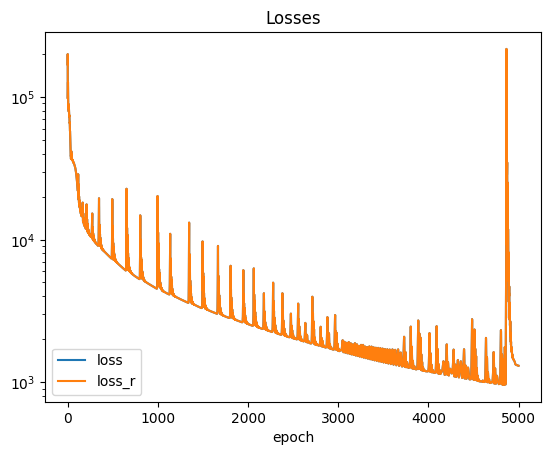

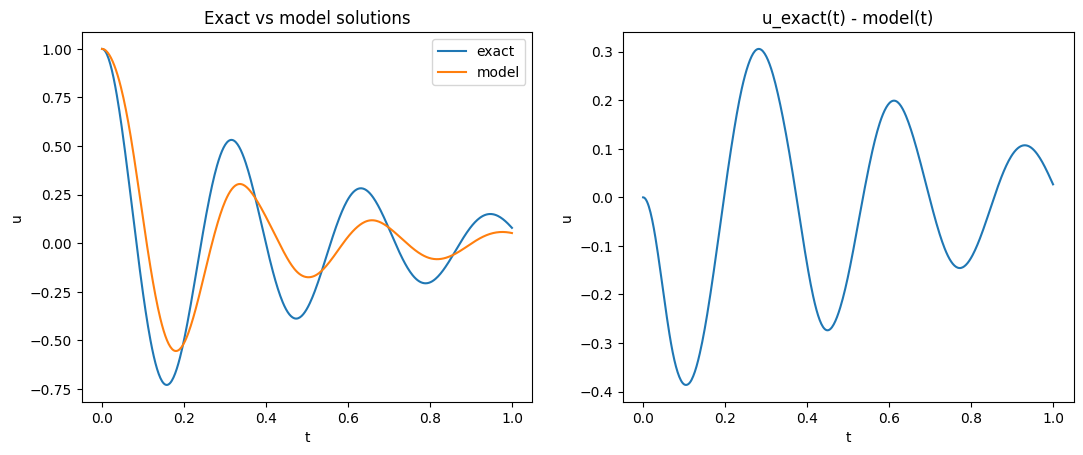

In [7]:
fig, ax = plt.subplots()
ax.set_title("Losses")
ax.set_xlabel("epoch")
ax.semilogy(loss_log, label="loss")
ax.semilogy(loss_r_log, label="loss_r")
#ax.semilogy(loss_ic_log, label="loss_ic")
ax.legend()
plt.show()

def oscillator(delta, omega0, t):
    assert delta < omega0
    omega = np.sqrt(omega0**2 - delta**2)
    phi = np.arctan(-delta / omega)
    A = 1.0 / ( 2.0 * np.cos(phi) )
    return 2.0 * A * torch.exp(-delta * t) * torch.cos(phi + omega * t)
u_exact = lambda t: oscillator(delta=delta, omega0=omega0, t=t)

with torch.no_grad():
    model = model.to("cpu")
    t = torch.linspace(*domain, 500).reshape(-1, 1)

    w, h = plt.rcParams['figure.figsize']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*w, h))
    ax1.set_title("Exact vs model solutions")
    ax1.set_xlabel("t")
    ax1.set_ylabel("u")
    ax1.plot(t, u_exact(t), label="exact")
    ax1.plot(t, model(t), label="model")
    ax1.legend()
    ax2.plot(t, u_exact(t) - model(t))
    ax2.set_title("u_exact(t) - model(t)")
    ax2.set_xlabel("t")
    ax2.set_ylabel("u")
    plt.show()